# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
np.mean([[1,2,3],  [4,5,6], [7,8,9]], axis=1)

array([2., 5., 8.])

In [5]:
def prepare_for_linear_classifier(train_X, test_X):
    print(train_X.shape, test_X.shape)
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    print(train_flat.shape, test_flat.shape)
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    print(mean_image.shape)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    print(train_flat_with_ones.shape)
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)
print(train_X.shape, val_X.shape)

(10000, 32, 32, 3) (1000, 32, 32, 3)
(10000, 3072) (1000, 3072)
(3072,)
(10000, 3073)
(9000, 3073) (1000, 3073)


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [6]:
x = [1,2,3]
ix = (1)
x[ix] = x[ix] + 1
x

[1, 3, 3]

In [7]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

9.0 [6.]
Gradient check passed!
5.0 [1. 1.]
Gradient check passed!
6.0 [[1. 1.]
 [1. 1.]]
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [8]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([[-10, 0, 10], [12, 34, 12]]))
print(probs)

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

[[2.06106005e-09 4.53978686e-05 9.99954600e-01]
 [2.78946809e-10 9.99999999e-01 2.78946809e-10]]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [9]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print(-np.log(probs))
linear_classifer.cross_entropy_loss(probs, 1)

[1.00067604e+01 5.00676044e+00 6.76044355e-03]


5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [10]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([2, 1, 0])
a[range(len(b)), b]

array([3, 5, 7])

In [11]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

1.551444713932051 [ 0.57611688 -0.78805844  0.21194156]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [12]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, )).astype(np.int) #///ERRRROOORRRR
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]]
Gradient check passed!
2.160204920616996 [[ 0.22715085  0.01130918  0.01130918 -0.2497692 ]
 [ 0.03641059  0.09897425  0.09897425 -0.23435909]
 [ 0.05072101  0.13787399 -0.32646899  0.13787399]]
Gradient check passed!


In [13]:
a = np.array([[1,2,3],[4,5,6],[7,8,10]])
a -= np.max(a, axis=1).reshape((a.shape[0],-1))
print(np.sum(np.exp(a), axis=1).reshape((3,1)))
np.exp(a)/np.sum(np.exp(a), axis=1).reshape((3,1))

[[1.50321472]
 [1.50321472]
 [1.18512235]]


array([[0.09003057, 0.24472847, 0.66524096],
       [0.09003057, 0.24472847, 0.66524096],
       [0.04201007, 0.1141952 , 0.84379473]])

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [14]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

1.0877576813083574 [[-0.44039854  0.44039854]
 [-0.4166856   0.4166856 ]
 [ 0.46411148 -0.46411148]]
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [15]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

0.11999999999999998 [[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]]
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [69]:
# TODO: Implement LinearSoftmaxClassifier.fit function
print(train_y)
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)


[9 9 2 ... 4 2 7]
(9000, 3073)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
Epoch 0, loss: 2.396655
(9000, 3073)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
Epoch 1, loss: 2.329534
(9000, 3073)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
Epoch 2, loss: 2.310666
(9000, 3073)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
Epoch 3, loss: 2.3

In [148]:
a = np.arange(100)
np.random.shuffle(a)
sec = np.arange(10, 100, 10)
np.array_split(a, sec)

[array([43,  6, 77, 16,  2, 69, 68, 52, 40, 33]),
 array([58, 60, 15, 62, 20, 76, 34, 23, 38, 47]),
 array([92, 29,  0, 53, 59, 31, 49, 41, 13, 72]),
 array([18, 21,  8, 80, 27, 90, 36, 61,  3, 86]),
 array([48, 50, 89, 24, 17, 57, 81, 78, 11, 63]),
 array([45, 64, 71, 22, 74,  5, 82, 39, 87, 10]),
 array([19, 83, 70, 42, 25, 66, 95, 91,  1, 44]),
 array([88, 79, 75, 84,  7, 94, 14, 55, 51, 46]),
 array([30, 12, 97, 73,  4,  9, 65, 85, 67, 98]),
 array([54, 96, 56, 37, 99, 35, 26, 93, 32, 28])]

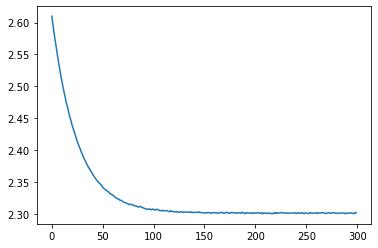

In [22]:
# let's look at the loss history!
plt.plot(loss_history)

In [45]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.114
Epoch 0, loss: 2.301086
Epoch 1, loss: 2.301363
Epoch 2, loss: 2.301968
Epoch 3, loss: 2.301722
Epoch 4, loss: 2.302229
Epoch 5, loss: 2.303452
Epoch 6, loss: 2.301739
Epoch 7, loss: 2.301953
Epoch 8, loss: 2.302390
Epoch 9, loss: 2.301276
Epoch 10, loss: 2.302297
Epoch 11, loss: 2.301789
Epoch 12, loss: 2.301831
Epoch 13, loss: 2.302081
Epoch 14, loss: 2.300625
Epoch 15, loss: 2.301968
Epoch 16, loss: 2.301594
Epoch 17, loss: 2.302140
Epoch 18, loss: 2.301738
Epoch 19, loss: 2.301771
Epoch 20, loss: 2.301555
Epoch 21, loss: 2.301862
Epoch 22, loss: 2.303046
Epoch 23, loss: 2.302448
Epoch 24, loss: 2.302104
Epoch 25, loss: 2.301727
Epoch 26, loss: 2.301728
Epoch 27, loss: 2.302405
Epoch 28, loss: 2.302222
Epoch 29, loss: 2.301101
Epoch 30, loss: 2.301226
Epoch 31, loss: 2.302018
Epoch 32, loss: 2.302585
Epoch 33, loss: 2.301654
Epoch 34, loss: 2.301803
Epoch 35, loss: 2.302470
Epoch 36, loss: 2.302540
Epoch 37, loss: 2.301451
Epoch 38, loss: 2.301836
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [57]:
from sklearn.model_selection import KFold
num_epochs = 20
batch_size = 300

learning_rates = [1e-1]
reg_strengths = [1e-7]
kf = KFold(n_splits=5)

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for i in range(len(learning_rates)):
    for train_index, test_index in kf.split(train_X):
        classifier.fit(train_X[train_index], train_y[train_index],
                       epochs=num_epochs, learning_rate=learning_rates[i],
                       batch_size=batch_size, reg=reg_strengths[i])
        pred = classifier.predict(train_X[test_index])
        accuracy = multiclass_accuracy(pred, train_y[test_index])
        if (best_val_accuracy < accuracy):
            best_val_accuracy = accuracy
            best_classifier = classifier
        print('best validation accuracy achieved: %f' % best_val_accuracy)


Epoch 0, loss: 2.067897
Epoch 1, loss: 2.084128
Epoch 2, loss: 2.136113
Epoch 3, loss: 2.032061
Epoch 4, loss: 2.092131
Epoch 5, loss: 1.999158
Epoch 6, loss: 2.141041
Epoch 7, loss: 2.076876
Epoch 8, loss: 2.065523
Epoch 9, loss: 2.091229
Epoch 10, loss: 2.138477
Epoch 11, loss: 2.061783
Epoch 12, loss: 2.056999
Epoch 13, loss: 2.117084
Epoch 14, loss: 2.098260
Epoch 15, loss: 2.005981
Epoch 16, loss: 2.076710
Epoch 17, loss: 2.028062
Epoch 18, loss: 2.090060
Epoch 19, loss: 2.046283
best validation accuracy achieved: 0.272222
Epoch 0, loss: 2.102376
Epoch 1, loss: 2.099828
Epoch 2, loss: 2.121793
Epoch 3, loss: 2.054984
Epoch 4, loss: 2.093379
Epoch 5, loss: 2.113264
Epoch 6, loss: 2.068464
Epoch 7, loss: 2.101001
Epoch 8, loss: 2.047870
Epoch 9, loss: 2.165455
Epoch 10, loss: 2.027303
Epoch 11, loss: 2.071796
Epoch 12, loss: 2.108808
Epoch 13, loss: 2.115055
Epoch 14, loss: 2.069713
Epoch 15, loss: 2.023264
Epoch 16, loss: 2.091877
Epoch 17, loss: 2.081927
Epoch 18, loss: 2.091928
E

# Какой же точности мы добились на тестовых данных?

In [59]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.215000
